In [ ]:
# %pip install scipy numpy pandas scikit-learn tensorflow

In [1]:
from pathlib import Path

import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import layers, models

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.4.0


In [2]:
# Base = src directory (where this notebook/script lives)
BASE_DIR = Path.cwd()          # if running from src/
DATA_DIR = BASE_DIR / "data"

HUGCDN_DIR = DATA_DIR / "HuGCDN2014-OXI"

print("Base dir:", BASE_DIR)
print("HuGCDN dir:", HUGCDN_DIR)


Base dir: d:\school\uni\sem 5\MLDL\TinyML UAS\src
HuGCDN dir: d:\school\uni\sem 5\MLDL\TinyML UAS\src\data\HuGCDN2014-OXI


In [3]:
from scipy.io import loadmat
import numpy as np
from pathlib import Path

HUGCDN_DIR = DATA_DIR / "HuGCDN2014-OXI"
print("HuGCDN dir:", HUGCDN_DIR)


def load_labels(path: Path) -> np.ndarray:
    d = loadmat(path)
    # Prefer per-minute labels
    if "salida_man_1m" in d:
        raw = d["salida_man_1m"]
    elif "salida_man" in d:
        raw = d["salida_man"]
    else:
        keys = [k for k in d.keys() if not k.startswith("__")]
        raw = d[keys[0]]
    labels = np.ravel(raw).astype(int)
    return labels


def extract_epoch_series(raw) -> list:
    """
    Convert MATLAB cell / numeric array into a list of 1D float arrays,
    one per epoch.
    """
    arr = np.array(raw)

    # Case 1: cell array -> dtype=object, each element is an array
    if arr.dtype == object:
        epochs = []
        for x in arr.ravel():
            x = np.array(x).astype(float).ravel()
            if x.size > 0:
                epochs.append(x)
        return epochs

    # Case 2: numeric 2D array (n_epochs, T)
    arr = np.squeeze(arr)
    if arr.ndim == 1:
        # single long vector, treat as one epoch
        return [arr.astype(float)]
    else:
        return [arr[i, :].astype(float).ravel() for i in range(arr.shape[0])]


def load_rr_epochs(path: Path) -> list:
    d = loadmat(path)
    for name in ["rr", "RR", "rr_1m", "RR_1m"]:
        if name in d:
            raw = d[name]
            break
    else:
        keys = [k for k in d.keys() if not k.startswith("__")]
        raw = d[keys[0]]
    return extract_epoch_series(raw)


def load_sat_epochs(path: Path) -> list:
    d = loadmat(path)
    for name in ["sat", "Sat", "SaO2", "satO2", "SaO2_1m"]:
        if name in d:
            raw = d[name]
            break
    else:
        keys = [k for k in d.keys() if not k.startswith("__")]
        raw = d[keys[0]]
    return extract_epoch_series(raw)


def resize_epoch(x: np.ndarray, target_len: int) -> np.ndarray:
    """
    Linearly resample a 1D array x to fixed length target_len.
    """
    x = np.asarray(x, dtype=float).ravel()
    if x.size == 0:
        return np.zeros(target_len, dtype=float)
    if x.size == target_len:
        return x
    old_idx = np.linspace(0.0, 1.0, num=x.size)
    new_idx = np.linspace(0.0, 1.0, num=target_len)
    return np.interp(new_idx, old_idx, x)


def load_hugcdn_subject(subject_id: str, T: int = 200):
    """
    subject_id: e.g., 'C1', 'D10', 'ND7'
    T: number of time steps per epoch after resampling

    Returns:
        X: (n_epochs, T, 2)  -> [RR_resampled_z, SAT_resampled_z]
        y: (n_epochs,)       -> 0/1 labels (normal / apnea)
    """
    label_path = HUGCDN_DIR / "LABELS" / f"{subject_id}.mat"
    rr_path    = HUGCDN_DIR / "RR"     / f"{subject_id}.mat"
    sat_path   = HUGCDN_DIR / "SAT"    / f"{subject_id}.mat"

    labels = load_labels(label_path)
    rr_ep  = load_rr_epochs(rr_path)
    sat_ep = load_sat_epochs(sat_path)

    n_labels = len(labels)
    n_rr     = len(rr_ep)
    n_sat    = len(sat_ep)

    n_epochs = min(n_labels, n_rr, n_sat)
    if n_epochs == 0:
        raise ValueError(f"No usable epochs for {subject_id}")

    labels = labels[:n_epochs]
    rr_ep  = rr_ep[:n_epochs]
    sat_ep = sat_ep[:n_epochs]

    # Resample each epoch to length T
    rr_resampled  = np.stack([resize_epoch(e, T) for e in rr_ep], axis=0)
    sat_resampled = np.stack([resize_epoch(e, T) for e in sat_ep], axis=0)

    # Per-epoch z-normalisation
    def z_norm(ep):
        mu = ep.mean(axis=1, keepdims=True)
        sigma = ep.std(axis=1, keepdims=True) + 1e-6
        return (ep - mu) / sigma

    rr_z  = z_norm(rr_resampled)
    sat_z = z_norm(sat_resampled)

    X = np.stack([rr_z, sat_z], axis=-1)  # (n_epochs, T, 2)
    y = labels.astype(int)

    return X, y


HuGCDN dir: d:\school\uni\sem 5\MLDL\TinyML UAS\src\data\HuGCDN2014-OXI


In [21]:
def load_all_hugcdn():
    label_dir = HUGCDN_DIR / "LABELS"
    subject_ids = sorted(f.stem for f in label_dir.glob("*.mat"))

    X_list = []
    y_list = []
    subject_idx = []

    for sid in subject_ids:
        try:
            X_s, y_s = load_hugcdn_subject(sid, T=200)  # you can tweak T
            X_list.append(X_s)
            y_list.append(y_s)
            subject_idx.extend([sid] * len(y_s))
            print(f"{sid}: X={X_s.shape}, y={y_s.shape}")
        except Exception as e:
            print(f"Skipping {sid} because of error: {e}")

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    subject_idx = np.array(subject_idx)

    print("Final shapes:")
    print("X:", X.shape)
    print("y:", y.shape)
    return X, y, subject_idx


X, y, subject_idx = load_all_hugcdn()


C1: X=(312, 200, 2), y=(312,)
C10: X=(448, 200, 2), y=(448,)
C11: X=(416, 200, 2), y=(416,)
C12: X=(441, 200, 2), y=(441,)
C13: X=(452, 200, 2), y=(452,)
C14: X=(443, 200, 2), y=(443,)
C15: X=(446, 200, 2), y=(446,)
C16: X=(452, 200, 2), y=(452,)
C17: X=(466, 200, 2), y=(466,)
C18: X=(451, 200, 2), y=(451,)
C19: X=(440, 200, 2), y=(440,)
C2: X=(434, 200, 2), y=(434,)
C20: X=(443, 200, 2), y=(443,)
C21: X=(447, 200, 2), y=(447,)
C22: X=(445, 200, 2), y=(445,)
C23: X=(449, 200, 2), y=(449,)
C24: X=(444, 200, 2), y=(444,)
C25: X=(438, 200, 2), y=(438,)
C26: X=(424, 200, 2), y=(424,)
C27: X=(432, 200, 2), y=(432,)
C28: X=(451, 200, 2), y=(451,)
C29: X=(430, 200, 2), y=(430,)
C3: X=(452, 200, 2), y=(452,)
C30: X=(445, 200, 2), y=(445,)
C31: X=(415, 200, 2), y=(415,)
C32: X=(439, 200, 2), y=(439,)
C33: X=(457, 200, 2), y=(457,)
C34: X=(448, 200, 2), y=(448,)
C35: X=(451, 200, 2), y=(451,)
C36: X=(438, 200, 2), y=(438,)
C37: X=(448, 200, 2), y=(448,)
C38: X=(440, 200, 2), y=(440,)
C4: X=(446,

In [22]:
# Shuffle once to mix subjects/epochs
X, y = shuffle(X, y, random_state=42)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

X_train.shape, X_val.shape, X_test.shape


((23356, 200, 2), (5005, 200, 2), (5006, 200, 2))

In [23]:
input_shape = X_train.shape[1:]  # (T, 2)
print("Input shape:", input_shape)

def build_rr_sat_cnn(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(32, kernel_size=7, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)  # binary: apnea vs normal

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_rr_sat_cnn(input_shape)
model.summary()


Input shape: (200, 2)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 2)]          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 32)           480       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 64)           10304     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 50, 128)           24704     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 1

In [24]:
EPOCHS = 20
BATCH_SIZE = 64

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
    ),
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)


Epoch 1/20
365/365 [==============================] - 4s 11ms/step - loss: 0.4839 - accuracy: 0.7873 - val_loss: 0.3386 - val_accuracy: 0.8599
Epoch 2/20
365/365 [==============================] - 4s 11ms/step - loss: 0.3219 - accuracy: 0.8696 - val_loss: 0.2914 - val_accuracy: 0.8795
Epoch 3/20
365/365 [==============================] - 4s 11ms/step - loss: 0.3025 - accuracy: 0.8788 - val_loss: 0.2772 - val_accuracy: 0.8823
Epoch 4/20
365/365 [==============================] - 7s 19ms/step - loss: 0.2836 - accuracy: 0.8856 - val_loss: 0.3046 - val_accuracy: 0.8747
Epoch 5/20
365/365 [==============================] - 4s 12ms/step - loss: 0.2799 - accuracy: 0.8844 - val_loss: 0.2922 - val_accuracy: 0.8749
Epoch 6/20
365/365 [==============================] - 4s 10ms/step - loss: 0.2669 - accuracy: 0.8923 - val_loss: 0.2590 - val_accuracy: 0.8919
Epoch 7/20
365/365 [==============================] - 4s 11ms/step - loss: 0.2633 - accuracy: 0.8947 - val_loss: 0.2901 - val_accuracy: 0.8787

In [13]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")


Test loss: 0.2499, Test accuracy: 0.8987


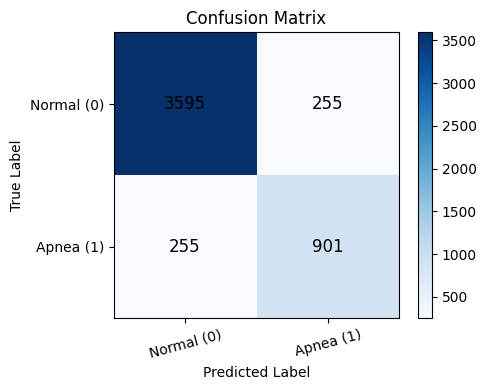


Classification Report:
              precision    recall  f1-score   support

           0     0.9338    0.9338    0.9338      3850
           1     0.7794    0.7794    0.7794      1156

    accuracy                         0.8981      5006
   macro avg     0.8566    0.8566    0.8566      5006
weighted avg     0.8981    0.8981    0.8981      5006



In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ---- 1) Get predictions ----
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int).ravel()

# ---- 2) Compute confusion matrix ----
cm = confusion_matrix(y_test, y_pred)
labels = ["Normal (0)", "Apnea (1)"]

# ---- 3) Plot using matplotlib ----
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

# Titles / axes
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

# Tick marks
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=15)
ax.set_yticklabels(labels)

# Write values inside the cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="black", fontsize=12)

# Add color bar
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# ---- 4) Optional classification report ----
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
